In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    precision_score, recall_score, accuracy_score, roc_auc_score, f1_score,
    matthews_corrcoef, cohen_kappa_score, confusion_matrix
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import featuretools as ft
from sklearn.metrics import accuracy_score, classification_report

# Функция для применения oversampling
def apply_oversampling(X, y):
    oversampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    return X_resampled, y_resampled

# Функция для применения undersampling
def apply_undersampling(X, y):
    undersampler = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(X, y)
    return X_resampled, y_resampled

def split_stratified_into_train_val_test(
    df_input,
    stratify_colname="y",
    frac_train=0.6,
    frac_val=0.15,
    frac_test=0.25,
    random_state=None,
):
    """
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    """

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError(
            "fractions %f, %f, %f do not add up to 1.0"
            % (frac_train, frac_val, frac_test)
        )

    if stratify_colname not in df_input.columns:
        raise ValueError("%s is not a column in the dataframe" % (stratify_colname))

    X = df_input  # Contains all columns.
    y = df_input[
        [stratify_colname]
    ]  # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(
        X, y, stratify=y, test_size=(1.0 - frac_train), random_state=random_state
    )

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(
        df_temp,
        y_temp,
        stratify=y_temp,
        test_size=relative_frac_test,
        random_state=random_state,
    )

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test


df = pd.read_csv('/mnt/c/3curse/mii/AIM-PIbd-31-Medvedkov-A-D/data/jio_mart_items.csv')
df.info()
df = df.sample(n=10000 , random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162313 entries, 0 to 162312
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   category      162313 non-null  object 
 1   sub_category  162313 non-null  object 
 2   href          162313 non-null  object 
 3   items         162280 non-null  object 
 4   price         162282 non-null  float64
dtypes: float64(1), object(4)
memory usage: 6.2+ MB


In [80]:
print(df['sub_category'].unique())

['Dining' 'Toys, Games & Fitness' 'Fragrances' 'Bags & Travel Luggage'
 'Girls' 'Home Decor' 'Boys' 'Stationery' 'Beverages' 'Staples' 'Men'
 'Mobiles & Tablets' 'Personal Care' 'Dairy & Bakery' 'Mom & Baby Care'
 'Snacks & Branded Foods' 'Women' 'Books' 'Auto Care' 'Electrical'
 'Furnishing' 'Accessories' 'Pets' 'Home Care' 'Mops, Brushes & Scrubs'
 'Furniture' 'Computers' 'Kitchen Appliances' 'Home Appliances' 'Cameras'
 'Make-Up' 'Garden & Outdoor' 'Disposables' 'Carpentry & work accessories'
 'Mom & Baby' 'Kitchenware' 'Power & Hand Tools' 'Pooja Needs'
 'Bathroom & Laundry Accessories' 'Office Products' 'TV & Speaker'
 'Personal Care & Grooming' 'Hair' 'Skin Care'
 'Paint, Wall Treatments & Supplies' 'Industrial & Scientific Supplies'
 'Infants' 'Kitchen & Bath Fixtures' 'Home Safety & Automation'
 'Fine Jewellery' 'Fruits & Vegetables' 'Apparel' 'Premium Fruits'
 'Phones' 'Bathroom & Laundry' 'Junior Boys' 'Tools & Appliances'
 'Smart Devices' "Men's Grooming" 'Gaming' 'Health Ca

Как бизнес-цели выделим следующие 2 варианта:
    1) Регрессия - предсказание цены по категории (для аналитических систем или улучшения алгоритмов ценообразования)
    2) Классификация - определение категории продукта по его подкатегории (для логистических или аналитических систем)
    
Однако данный датасет весьма плоо подходит для подобных задач.

Выполним подготовку данных

In [81]:
# df.fillna({"category": "NaN", "sub_category": "NaN", "href" : "NaN", "items" : "NaN", "price" : "NaN" }, inplace=True)
df = df.dropna()
data = df.copy()

value_counts = data["category"].value_counts()
rare = value_counts[value_counts < 100].index
data = data[~data["category"].isin(rare)]

data1 = pd.get_dummies(data, columns=['category', 'sub_category'], drop_first=True)

# label_encoder = LabelEncoder()
# data1['sub_category'] = label_encoder.fit_transform(data['sub_category'])
# data1['category'] = label_encoder.fit_transform(data['category'])
# data1['items'] = label_encoder.fit_transform(data['items'])


Определить достижимый уровень качества модели для каждой задачи. На основе имеющихся данных уровень качества моделей регрессии будет низким, поскольку цена слабо коррелирует с категорией (кроме некоторых исключений).

Построим конвейер.

In [82]:
print(data1.columns)
data1.info()

Index(['href', 'items', 'price', 'category_Electronics', 'category_Fashion',
       'category_Groceries', 'category_Home & Kitchen', 'sub_category_Apparel',
       'sub_category_Auto Care', 'sub_category_Bags & Travel Luggage',
       'sub_category_Bathroom & Laundry',
       'sub_category_Bathroom & Laundry Accessories', 'sub_category_Beverages',
       'sub_category_Books', 'sub_category_Boys', 'sub_category_Cameras',
       'sub_category_Carpentry & work accessories', 'sub_category_Computers',
       'sub_category_Dairy & Bakery', 'sub_category_Dining',
       'sub_category_Disposables', 'sub_category_Electrical',
       'sub_category_Fragrances', 'sub_category_Fruits & Vegetables',
       'sub_category_Furnishing', 'sub_category_Furniture',
       'sub_category_Gaming', 'sub_category_Garden & Outdoor',
       'sub_category_Girls', 'sub_category_Hair',
       'sub_category_Handloom & Handicraft',
       'sub_category_Hardware & Plumbing', 'sub_category_Health Care Devices',
       '

In [83]:
X_reg = data1.drop(['href', 'items', 'price'], axis=1)
y_reg = data1['price']

# Разделение данных
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Выбор моделей для регрессии
models_reg = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42)
}

# Создание конвейера для регрессии
pipelines_reg = {}
for name, model in models_reg.items():
    pipelines_reg[name] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

# Определение сетки гиперпараметров для регрессии
param_grids_reg = {
    'Linear Regression': {},
    'Random Forest Regressor': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30]
    },
    'Gradient Boosting Regressor': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
}

# Настройка гиперпараметров для регрессии
best_models_reg = {}
for name, pipeline in pipelines_reg.items():
    grid_search = GridSearchCV(pipeline, param_grids_reg[name], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_reg, y_train_reg)
    best_models_reg[name] = {
        'pipeline': grid_search.best_estimator_,
        'best_params': grid_search.best_params_
    }
    print(f'Best parameters for {name}: {grid_search.best_params_}')

# Обучение моделей и оценка качества
for model_name in best_models_reg.keys():
    print(f"Model: {model_name}")
    model_pipeline = best_models_reg[model_name]['pipeline']
    model_pipeline.fit(X_train_reg, y_train_reg)

    y_train_predict = model_pipeline.predict(X_train_reg)
    y_test_predict = model_pipeline.predict(X_test_reg)

    best_models_reg[model_name]["preds_train"] = y_train_predict
    best_models_reg[model_name]["preds_test"] = y_test_predict

    best_models_reg[model_name]["MSE_train"] = mean_squared_error(y_train_reg, y_train_predict)
    best_models_reg[model_name]["MSE_test"] = mean_squared_error(y_test_reg, y_test_predict)
    best_models_reg[model_name]["R2_train"] = r2_score(y_train_reg, y_train_predict)
    best_models_reg[model_name]["R2_test"] = r2_score(y_test_reg, y_test_predict)
    best_models_reg[model_name]["MAE_train"] = mean_absolute_error(y_train_reg, y_train_predict)
    best_models_reg[model_name]["MAE_test"] = mean_absolute_error(y_test_reg, y_test_predict)

Best parameters for Linear Regression: {}
Best parameters for Random Forest Regressor: {'model__max_depth': None, 'model__n_estimators': 300}
Best parameters for Gradient Boosting Regressor: {'model__learning_rate': 0.01, 'model__max_depth': 7, 'model__n_estimators': 300}
Model: Linear Regression
Model: Random Forest Regressor
Model: Gradient Boosting Regressor


Accuracy: 0.991495747873937
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.90      0.94       131
           1       0.99      1.00      0.99       241
           2       1.00      1.00      1.00       307
           3       0.98      1.00      0.99       573
           4       1.00      1.00      1.00       747

    accuracy                           0.99      1999
   macro avg       0.99      0.98      0.98      1999
weighted avg       0.99      0.99      0.99      1999



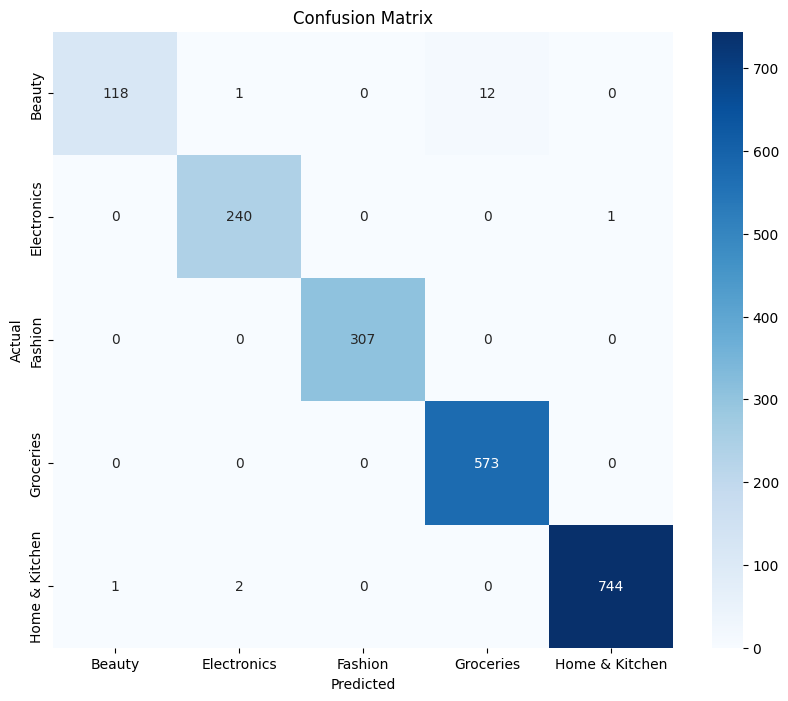

In [84]:
# Кодирование категориальных данных
label_encoder = LabelEncoder()
data['sub_category_encoded'] = label_encoder.fit_transform(data['sub_category'])

# Определение признаков (X) и целевой переменной (y)
X = data[['sub_category_encoded']]  # Используем закодированный sub_category
y = label_encoder.fit_transform(data['category'])  # Кодируем category

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Создание и обучение модели
classifier = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
classifier.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = classifier.predict(X_test)

# Оценка качества модели
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Модель классификации показывает неплохие результаты, что логично, учитывая структуру датасета.

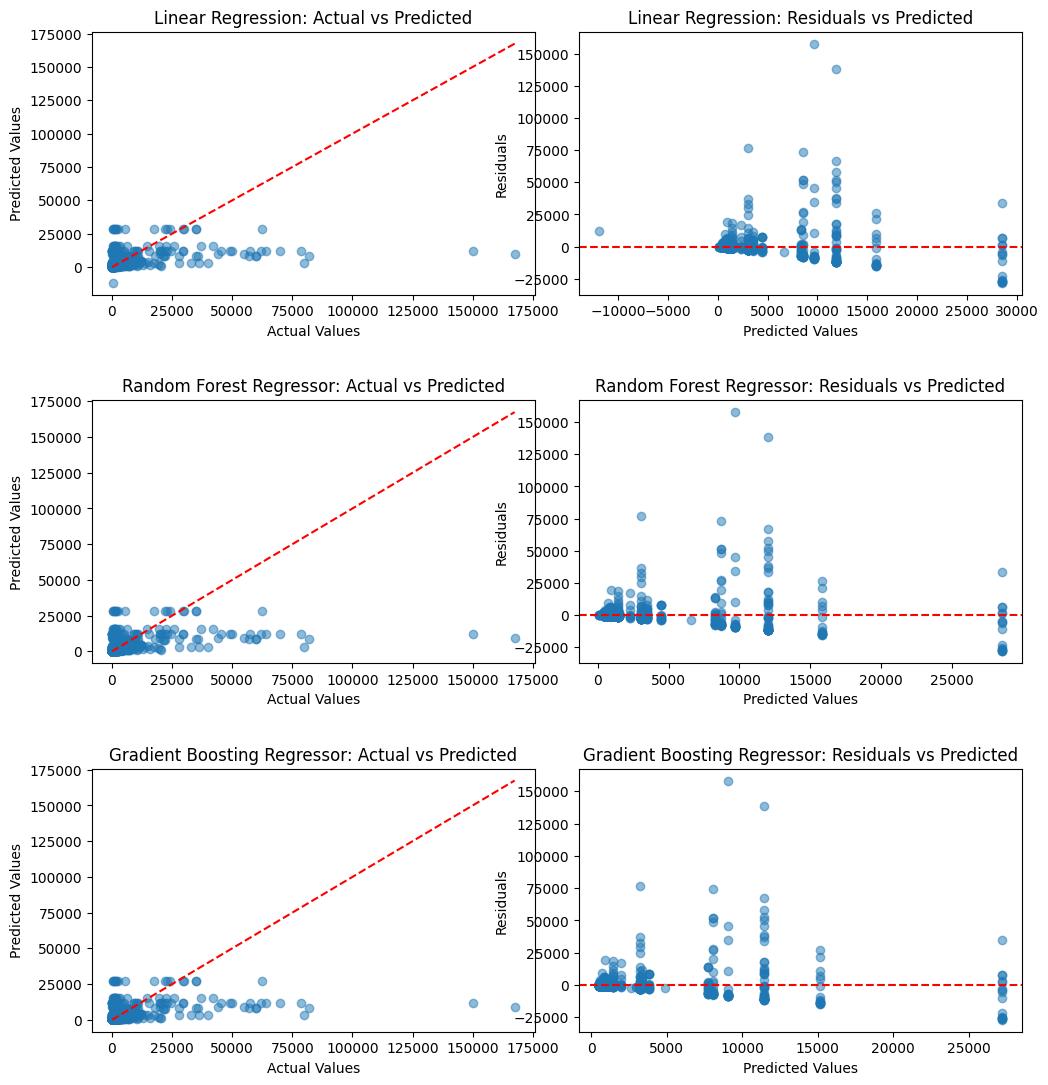

In [85]:
_, ax = plt.subplots(3, 2, figsize=(12, 10), sharex=False, sharey=False)
ax = ax.flatten()

for index, (name, model) in enumerate(best_models_reg.items()):
    model_pipeline = model['pipeline']
    y_pred_reg = model_pipeline.predict(X_test_reg)

    # График фактических значений против предсказанных значений
    ax[index * 2].scatter(y_test_reg, y_pred_reg, alpha=0.5)
    ax[index * 2].plot([min(y_test_reg), max(y_test_reg)], [min(y_test_reg), max(y_test_reg)], color='red', linestyle='--')
    ax[index * 2].set_xlabel('Actual Values')
    ax[index * 2].set_ylabel('Predicted Values')
    ax[index * 2].set_title(f'{name}: Actual vs Predicted')

    # График остатков
    residuals = y_test_reg - y_pred_reg
    ax[index * 2 + 1].scatter(y_pred_reg, residuals, alpha=0.5)
    ax[index * 2 + 1].axhline(y=0, color='red', linestyle='--')
    ax[index * 2 + 1].set_xlabel('Predicted Values')
    ax[index * 2 + 1].set_ylabel('Residuals')
    ax[index * 2 + 1].set_title(f'{name}: Residuals vs Predicted')


plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.1)
plt.show()

Модель регресии демонстрирует ужасные результаты ввиду недостаточной корреляции между целеовй характеристикой и строковыми значениями.